In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import os

from astropy.io import fits

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

from scipy.optimize import curve_fit, minimize

from matplotlib.lines import Line2D

import copy

In [2]:
# Time stamp
tstamp = time.strftime("%d_%m_%Y", time.localtime())

# Current working directory
CWD = "/".join(os.getcwd().split("/")[:-2])

# Define paper directory:
CPD = "/home/ekaterina/Documents/002_writing/multiperiod-flares-draft"

# Define in- and output paths
valdir = f'{CPD}/values/'
figdir = f'{CPD}/figures/'
dirr = f'{CWD}/data'

# GET ALL THE SPECTRA:

# SALT1 and SALT2
# ------------------------------------------------------------------------

sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", 
                  delimiter="\s+", names=["lambd", "flux", "flux_err"])
# mask an emission line that is only seen in SALT but not in CARMENES
sp1.loc[((sp1["lambd"] > 7949.2) & (sp1["lambd"] < 7949.8)), "flux"] = np.nan
sp1.lambd = sp1.lambd + .4
sp1 = sp1.dropna(how="any")

sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", 
                  delimiter="\s+", names=["lambd", "flux", "flux_err"])
# mask an emission line that is only seen in SALT but not in CARMENES
sp2.loc[((sp2["lambd" ]> 7949.2) & (sp2["lambd"] < 7949.8)), "flux"] = np.nan
sp2.lambd = sp2.lambd + .22
sp2 = sp2.dropna(how="any")


salt = {"TIC 44984200": [sp1, "r", 34.8, 0.8],
        "TIC 277539431": [sp2, "b", 38.6, 1.0]}    


In [3]:
# Get non-rotating spectra from CARMENES
# ------------------------------------------------------------------------

# Spectral types come from the CARMENES data base on Vizier
carms = {"CN Leo": 
         ["M6", "carmenes_cnleo_vis.fits", 3.05, "cnleo","solid"],
         "LP 731-058": 
         ["M6.5", "carmenes_lp731_m65_vis.fits", 1.05, "lp731", "dashed"],
         "Teegarden's Star": 
         ["M7", "carmenes_teegarden_vis.fits", 3.45, "teega", "dotted"],}

for s, l in carms.items():
    hdu = fits.open(f"{dirr}/carmenes/{l[1]}")
    lambd = hdu[4].data.flatten().byteswap().newbyteorder() - l[2]
    flux = hdu[1].data.flatten().byteswap().newbyteorder()
    sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
    sp4 = sp4.dropna(how="any")
    l.append(sp4)


# --------------------------------------
# Pick spectral region


# Pick the Rubidium line region
# (left edge, right edge, center of line)
wavmin, wavmax, line_center = (7938,7955,7948) 

In [6]:
from eniric import broaden
df = pd.read_csv("/home/ekaterina/Documents/001_science/MalachiteMountains/data/summary/12_02_2021_vsinis.csv")
df

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/__init__.py:23: UserWarning: Using the default config.yaml file located at /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/config.yaml. This is likely NOT what you want and you will not be able to change any of the config values. Please use config.copy_file(<path>) to copy a version of the default config for your own project.
  UserWarning,


,TIC,template,vsini,err
0,TIC 277539431,CN Leo,39.106945,1.427398
1,TIC 277539431,LP 731-058,38.543634,1.738451
2,TIC 277539431,Teegarden's Star,37.646887,1.582698
3,TIC 44984200,CN Leo,34.586714,1.202680
4,TIC 44984200,LP 731-058,34.640706,1.424261
5,TIC 44984200,Teegarden's Star,35.359902,1.274699









  0%|          | 0/405 [00:00<?, ?it/s]






100%|██████████| 405/405 [00:00<00:00, 2767.04it/s]A







  0%|          | 0/405 [00:00<?, ?it/s]






100%|██████████| 405/405 [00:00<00:00, 3816.78it/s]


Text(0, 0.5, 'Norm. flux')

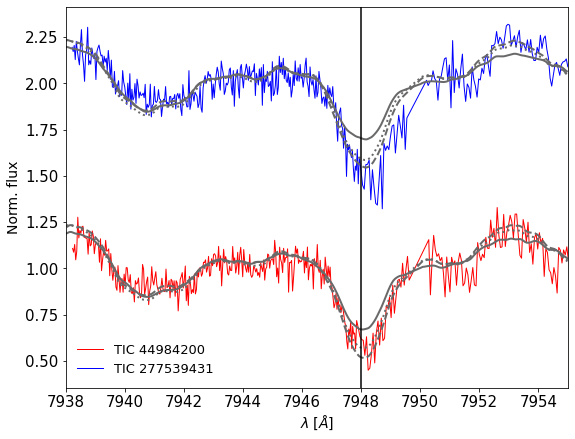

In [128]:
plt.figure(figsize=(9,7))

off = 0

for key, l in carms.items():
    sp = l[5]
    modelwav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    model = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
#     plt.plot(modelwav,model/np.median(mflux)+off , linewidth=1, label=f"{key} ({l[0]})")
    
    ooff = 0
    for j,spc in salt.items():

        sp, c, res, err = spc
        result = df.loc[(df.template == key) & (df.TIC == j)].iloc[0]
        res, err = result.vsini, result.err
#         print(result)
        wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
        mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
        if key == "CN Leo":
            plt.plot(wav+.2,mflux/np.median(mflux) + ooff , linewidth=1, label=f"{j}", c=c)
        b = []
        for vsini in [res]:#, res+3*err, res-3*err]:
            b_ = (broaden.rotational_convolution(wav, modelwav, model, vsini, epsilon=0.6) /
                  np.median(model) +
                  ooff)
            b.append(b_)
        plt.plot(wav,b[0], c="dimgrey", linestyle=l[4], linewidth=2)
#         plt.fill_between(wav, b[1],b[2], facecolor="grey")

        ooff +=1

# for l,spc in salt.items():

#     sp, c, res, err = spc

#     wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
#     mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
#     plt.plot(wav,mflux/np.median(mflux) + off , linewidth=1, label=f"{l}", c=c)
#     for vsini in [res, res+err]:
#         broadened = broaden.rotational_convolution(wav, sp.lambd, model.flux, vsini, epsilon=0.6)
#         plt.plot(wav, broadened/np.median(mflux) + off, c="k")
    
#     off +=2
    
    
plt.axvline(line_center, c="k")

plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
#plt.ylim(0,4.6)
plt.legend(fontsize=13, frameon=False)
plt.xlabel(r"$\lambda\;[\AA]$", fontsize=14)
plt.ylabel(r"Norm. flux", fontsize=14)
# plt.savefig(f"../plots/vsini/{tstamp}_salt12_{wavmin:.0f}_{wavmax:.0f}.png", dpi=300);



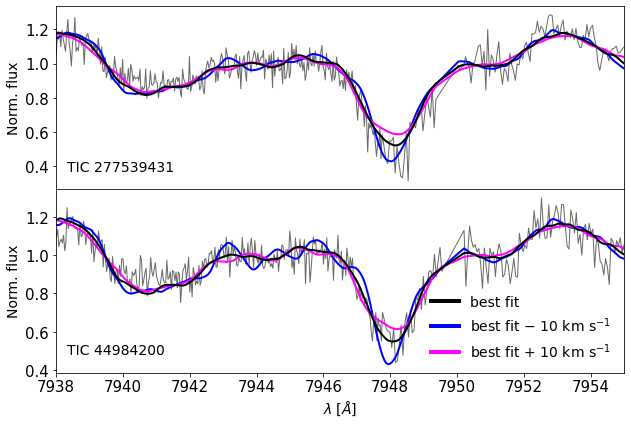

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9,6), sharex=True)
axes = list(axes)
axes_=copy.copy(axes)
off = 0

#     plt.plot(modelwav,model/np.median(mflux)+off , linewidth=1, label=f"{key} ({l[0]})")

for j,spc in salt.items():
    
    if j == "TIC 44984200":
        key = "Teegarden's Star"
    elif j == "TIC 277539431":
        key = "LP 731-058"
    l=carms[key]
    sp = l[5]
    modelwav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    model = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values

    median = np.nanmedian(sp.loc[(sp.lambd<7946) | (sp.lambd>7950),"flux"].values)
    
    ax = axes.pop()
    sp, c, res, err = spc
    result = df.loc[(df.template == key) & (df.TIC == j)].iloc[0]
    res, err = result.vsini, result.err
#         print(result)
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    
    medianf = np.nanmedian(mflux[np.where((wav<7946) | (wav>7950))])
    ax.plot(wav,mflux/medianf  , linewidth=1, c="dimgrey",zorder=-20)
    ax.text(0.02,0.1,j,transform=ax.transAxes,fontsize=14)
    b = []
    col_ = ["magenta","blue","k"]
    leg_ = [r"best fit $+$ 10 km s$^{-1}$",r"best fit $-$ 10 km s$^{-1}$","best fit"]
    col, leg = copy.copy(col_), copy.copy(leg_)
#     ax.legend(fontsize=13, frameon=False)
    ax.set_ylabel(r"Norm. flux", fontsize=14)
    for vsini in [res, res-10, res+10]:#, res+3*err, res-3*err]:
        _ = broaden.rotational_convolution(wav, modelwav, model, vsini, epsilon=0.6) 
        if vsini==res:
            g = lambda x: np.sum((_ / x - mflux/medianf)**2)
            median = np.nanmedian(_[np.where((wav<7946) | (wav>7950))])
            R = minimize(g, median)
            zorder=1
        else:
            zorder=-10
        b_ = (_ / R.x)
        b.append(b_)
        c = col.pop()

        ax.plot(wav,b_, c=c, linewidth=2,zorder=zorder)
       

legend_elements3 = [Line2D([0], [0], color=x, lw=4, 
                          label=y) for (x,y) in list(zip(col_, leg_))][::-1]


axes_[1].legend(handles=legend_elements3, fontsize=14, frameon=False, loc=4)


plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
#plt.ylim(0,4.6)
plt.xlabel(r"$\lambda\;[\AA]$", fontsize=14)
plt.tight_layout()
# plt.savefig(f"../plots/vsini/{tstamp}_salt12_{wavmin:.0f}_{wavmax:.0f}.png", dpi=300);

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"/home/ekaterina/Documents/002_writing/multiperiod-flares-draft-mnras/figures/saltspectra.png", dpi=300);